# DNN 网络识别手写图片
本节仍属于 [PyTorch深度学习：深度神经网络（DNN）](https://www.bilibili.com/video/BV1Z8411R7PH) 的范畴，与之前的激活函数略有不同，故另起一页。

此外，由于反复学习了一遍 MLP ，同时推荐学习唐一旦老师的 [徒手实现卷积神经网络--图像识别初体验以及模型过拟合](https://www.bilibili.com/video/BV1Gz421b7vb) ，
此篇笔记由两位老师的讲解共同组成。

唐一旦老师推荐一个模型的搭建过程可以是：初始化数据集、搭建模型网络、撰写评估函数、训练模型。之所以先撰写评估函数是为了检验之前撰写的代码准确性，与了解评估模型好坏的指标。


In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline

# 数据集相关
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

接下来就要对图像进行张量化和归一化处理，具体的解释可以参考 [https://juejin.cn/post/7087397616731815966](https://juejin.cn/post/7087397616731815966)

下面对两个过程进行简单的解释：

## ToTensor 张量化

这个函数会吧 PIL Image 对象转化为 Numpy 数组，具体来说他干了两个事情：

- 将 (H x W x C) 格式的图片转化为 (C x H x W) ， HWC 格式的图片是以 高、宽、颜色 进行存储的，即读取的时候需要通过 image\[h, w, c\] 来获取图片像素值，而 CHW 格式存取时使用的是类似 image\[c, h, w\] 来获取图片像素值，前者是先定位高宽再取像素维度，后者是先取维度再取高宽。这样做的好处是，在读取的时候像素永远是同一个通道排在一起的，有助于神经网络理解同维度像素左右的联系。
- 将像素值 \[0, 255\] 的区间映射为 \[0.0, 1.0\] 的区间，将大数据变小，对神经网络更加友好。

## Normalize 归一化

将 \[\~0.0, \~1.0\] 之间的数据变为 \[\~-1.0, \~1.0\] 之间，使其整个训练集的输入均值为 0 ，方差为 1，让神经网络中的 bias 可以在负数与正数内取值，接近原点，使梯度下降更高效，加快收敛速度。

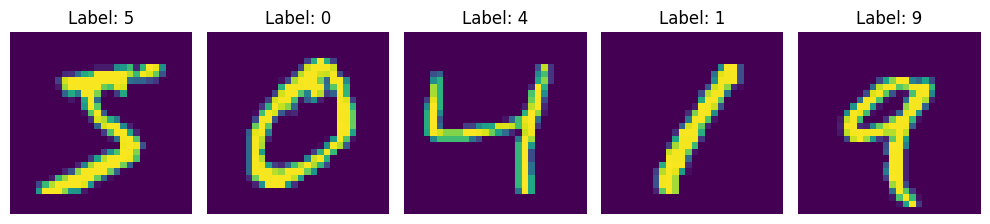

In [2]:
# 转化为张量与归一化处理
# transform = transforms.Compose(  # 将多个图像变换操作组合在一起
#     [
#         transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
#     ]
# )

# 下载训练集
train_Data_raw = datasets.MNIST(
    root='./datasets/mnist/',
    train=True,
    download=True,
    transform=None
)
test_Data_raw = datasets.MNIST(
    root='./datasets/mnist/',
    train=False,
    download=True,
    transform=None
)

# 展示 5 张照片
plt.figure(figsize=(10, 4))
for _ in range(5):
    img, label = train_Data_raw[_]
    plt.subplot(1, 5, _ + 1)
    plt.imshow(img)  # cmap=plt.cm.binary 色板颜色设置为黑白
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()  # 展示彩色是因为 plt 是用于数学绘图的，这样是把所有颜色值一样的像素给到不同的高度的颜色了（参考等高图）


In [3]:
# 手动进行张量化和归一化
class DatasetMNIST(Dataset):
    def __init__(self, raw):
        super().__init__()
        self.raw = raw
        self.imgs = []
        self.labels = []

        self.ToTensor = transforms.ToTensor()
        self.Normalize = transforms.Normalize((0.1307,), (0.3081,))

        # 其实可以一把写完，但是这里为了展示中间过程所以拆开
        for img, label in self.raw:
            self.imgs.append(self.ToTensor(img))
            self.labels.append(label)

        print(self.imgs[0])

        for i in range(len(self.imgs)):
            self.imgs[i] = self.Normalize(self.imgs[i])

        print(self.imgs[0])

    def __getitem__(self, index):
        return self.imgs[index], self.labels[index]

    def __len__(self):
        return len(self.imgs)


train_Data = DatasetMNIST(train_Data_raw)
test_Data = DatasetMNIST(test_Data_raw)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [4]:
# 构建神经网络
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),  # 把输入摊平
            nn.Linear(28 * 28, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
# 批处理数据集
train_loader = DataLoader(train_Data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_Data, batch_size=64, shuffle=True)

In [6]:
# 初始化训练参数
net = net().to('cuda')

epoch = 10
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()  # 损失器
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  # 优化器

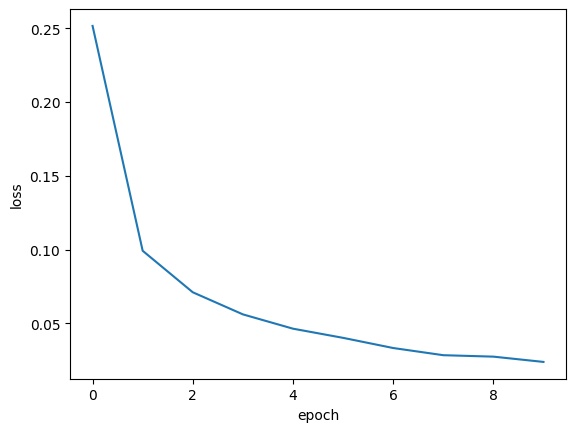

In [7]:
# 开始训练
total_losses = []

for epoch_ in range(epoch):
    batch_losses = []
    for x, y in train_loader:
        x = x.to('cuda')
        y = y.to('cuda')
        pred = net(x)
        loss = loss_fn(pred, y)
        batch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_losses.append(sum(batch_losses) / len(batch_losses))

Fig = plt.figure()
plt.plot(range(epoch), total_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [8]:
# 测试模型
total = 0
correct = 0
with torch.no_grad():
    for x, y in test_loader:
        x = x.to('cuda')
        y = y.to('cuda')
        pred = net(x)
        correct += torch.sum(torch.argmax(pred, dim=1) == y)
        total += y.size(0)

print(f"正确率：{correct / total * 100:.2f}%")

正确率：97.88%


In [9]:
from tools.ipynb_draw import DrawCanvas
from IPython.display import display
from ipywidgets import Button
from PIL import Image

dc = DrawCanvas(width=58, height=58)

callback_button = Button(description="识别")

def callback(_):
    with dc.out:
        try:
            np_img = dc.canvas.get_image_data(width=58, height=58)
            img = Image.fromarray(np_img)
            transform = transforms.Compose([
                transforms.Grayscale(),  # 如果是彩色图像转为灰度
                transforms.Resize((28, 28)),  # 调整大小为28x28
                transforms.ToTensor(),  # 转为张量并归一化到[0,1]
                transforms.Normalize((0.1307,), (0.3081,))  # 标准化到[-1,1]
            ])

            # 对图像进行预处理
            input_tensor = transform(img).unsqueeze(0).to('cuda')  # 添加batch维度 (1, 1, 28, 28)

            # 3. 前向传播
            with torch.no_grad():  # 不需要计算梯度
                output = net(input_tensor)
                prediction = torch.argmax(output, dim=1).item()  # 获取预测类别
                print(prediction)
        except BaseException as e:
            print(str(e))

callback_button.on_click(callback)


layout = dc.get_layout()
layout.children[1].children = layout.children[1].children + (callback_button,)
display(layout)

实际上对于纯神经网络输入的识别效果并不好，必须是很接近训练集的数据才能准确的识别，对不同类型的图片的泛化能力其实不太行。

# 损失函数说明

CrossEntropyLoss（交叉熵损失）、MSELoss（均方误差损失）和BCELoss（二元交叉熵损失）是深度学习中常用的损失函数，它们在应用场景、数学形式和适用任务上有显著差异。以下是它们的异同点分析：

---

### **1. 核心区别**
| **损失函数**       | **主要应用场景**               | **输出类型**       | **数学形式**                          | **特点**                                                                 |
|--------------------|-------------------------------|--------------------|---------------------------------------|--------------------------------------------------------------------------|
| **CrossEntropyLoss** | 多分类任务（单标签）           | 概率分布（Softmax）| \(-\sum_{c=1}^C y_c \log(p_c)\)       | 结合Softmax，直接优化多类概率分布，对错误分类敏感。                       |
| **BCELoss**         | 二分类任务或多标签分类         | 独立概率（Sigmoid）| \(-\frac{1}{N}\sum_{i=1}^N [y_i \log(p_i) + (1-y_i)\log(1-p_i)]\) | 每个输出节点独立计算二元概率，需显式Sigmoid激活。                         |
| **MSELoss**         | 回归任务（连续值预测）         | 任意实数           | \(\frac{1}{N}\sum_{i=1}^N (y_i - p_i)^2\) | 对异常值敏感，假设误差服从高斯分布，分类任务中可能导致梯度消失。           |

---

### **2. 相同点**
- **目标**：均用于衡量模型预测值与真实值的差异，指导模型参数优化。
- **可微性**：均为可微函数，支持梯度下降法优化。

---

### **3. 关键差异**
#### **(1) 任务类型**
- **CrossEntropyLoss**：专为**单标签多分类**设计（如MNIST手写数字识别）。
- **BCELoss**：适用于**二分类**或**多标签分类**（如同时预测多个疾病的概率）。
- **MSELoss**：主要用于**回归问题**（如房价预测），分类任务中效果较差。

#### **(2) 概率建模**
- **CrossEntropyLoss**：隐含Softmax，强制输出为概率分布（\(\sum p_c = 1\)）。
- **BCELoss**：对每个输出节点单独应用Sigmoid，概率独立（适合非互斥类别）。
- **MSELoss**：无概率约束，直接拟合数值。

#### **(3) 梯度特性**
- **CrossEntropyLoss**：梯度与误差成比例（\(p_c - y_c\)），错误分类时梯度大，收敛快。
- **BCELoss**：类似但对每个节点独立计算。
- **MSELoss**：梯度与误差线性相关（\(2(y_i - p_i)\)），在分类任务中可能导致梯度饱和（如Sigmoid输出接近0/1时）。

#### **(4) 异常值鲁棒性**
- MSELoss对异常值敏感（平方放大误差），而交叉熵损失对概率偏差更敏感。

---

### **4. 选择建议**
- **多分类任务**：优先使用`CrossEntropyLoss`（PyTorch中结合Softmax，无需手动激活）。
- **二分类/多标签分类**：使用`BCELoss` + `Sigmoid`。
- **回归任务**：使用`MSELoss`或`HuberLoss`（对异常值鲁棒）。
- **避免**：用MSELoss处理分类问题（概率拟合不合理，梯度不稳定）。


# 唐一旦老师的代码
由于老师写的比较优美，我这边直接 copy 过来，然后加一点注释

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


torch.manual_seed(12046)

dataset = datasets.MNIST(root='./datasets/mnist/', train=True, download=True, transform=transforms.ToTensor())

In [2]:
train_set, val_set = random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root='./datasets/mnist/', train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_set, batch_size=500, shuffle=True)
val_loader = DataLoader(val_set, batch_size=500, shuffle=True)
test_loader = DataLoader(test_set, batch_size=500, shuffle=True)

In [3]:
model = nn.Sequential(
    nn.Linear(784, 30), nn.Sigmoid(),
    nn.Linear( 30, 20), nn.Sigmoid(),
    nn.Linear( 20, 10)
)

In [11]:
eval_iters = 10

def estimate_loss(model):
    re = {}
    # 将模型切换为评估模式
    model.eval()
    re['train'] = _loss(model, train_loader)
    re['val'] = _loss(model, val_loader)
    re['test'] = _loss(model, test_loader)
    # 将模型切换为训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, dataloader):
    # 估算模型效果
    loss = []
    acc = []
    data_iter = iter(dataloader)
    for t in range(eval_iters):
        inputs, labels = next(data_iter)
        # inputs: (500, 1, 28, 28)
        # labels: (500)
        B, C, H, W = inputs.shape   # 第一个 B 是批次大小
        logits = model(inputs.view(B, -1))
        loss.append(F.cross_entropy(logits, labels))
        # preds = torch.argmax(F.softmax(logits, dim=-1), dim=-1)
        preds = torch.argmax(logits, dim=-1)
        acc.append((preds == labels).sum() / B)
    re = {
        'loss': torch.tensor(loss).mean().item(),
        'acc': torch.tensor(acc).mean().item()
    }
    return re

In [12]:
estimate_loss(model)

{'train': {'loss': 2.3743958473205566, 'acc': 0.10120000690221786},
 'val': {'loss': 2.3680973052978516, 'acc': 0.10480000078678131},
 'test': {'loss': 2.3629441261291504, 'acc': 0.10699999332427979}}

In [13]:
def train_model(model, optimizer, epochs=10, penalty=False):
    lossi = []
    for e in range(epochs):
        for data in train_loader:
            inputs, labels = data
            B, C, H, W = inputs.shape
            logits = model(inputs.view(B, -1))
            loss = F.cross_entropy(logits, labels)
            lossi.append(loss.item())
            if penalty:
                w = torch.cat([p.view(-1) for p in model.parameters()])
                loss += 0.001 * w.abs().sum() + 0.002 * w.square().sum()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        stats = estimate_loss(model)
        train_loss = f'{stats["train"]["loss"]:.3f}'
        val_loss = f'{stats["val"]["loss"]:.3f}'
        test_loss = f'{stats["test"]["loss"]:.3f}'
        print(f'epoch {e} train {train_loss} val {val_loss} test {test_loss}')
    return lossi

In [14]:
loss = {}
model = nn.Sequential(
    nn.Linear(784, 30), nn.Sigmoid(),
    nn.Linear( 30, 20), nn.Sigmoid(),
    nn.Linear( 20, 10)
)

loss['mlp'] = train_model(model, optim.SGD(model.parameters(), lr=0.01))

epoch 0 train 2.319 val 2.316 test 2.312
epoch 1 train 2.304 val 2.303 test 2.303
epoch 2 train 2.301 val 2.300 test 2.300
epoch 3 train 2.300 val 2.300 test 2.300
epoch 4 train 2.300 val 2.299 test 2.298
epoch 5 train 2.299 val 2.298 test 2.297
epoch 6 train 2.299 val 2.298 test 2.298
epoch 7 train 2.297 val 2.297 test 2.296
epoch 8 train 2.297 val 2.296 test 2.296
epoch 9 train 2.295 val 2.296 test 2.296


In [15]:
model = nn.Sequential(
    nn.Linear(784, 30), nn.ReLU(),
    nn.Linear( 30, 20), nn.ReLU(),
    nn.Linear( 20, 10)
)

loss['mlp_relu'] = train_model(model, optim.SGD(model.parameters(), lr=0.01))

epoch 0 train 2.290 val 2.290 test 2.290
epoch 1 train 2.262 val 2.261 test 2.261
epoch 2 train 2.212 val 2.210 test 2.211
epoch 3 train 2.122 val 2.122 test 2.117
epoch 4 train 1.953 val 1.950 test 1.945
epoch 5 train 1.720 val 1.711 test 1.707
epoch 6 train 1.454 val 1.453 test 1.447
epoch 7 train 1.208 val 1.224 test 1.205
epoch 8 train 1.022 val 1.018 test 1.001
epoch 9 train 0.886 val 0.878 test 0.875


In [16]:
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(),  # 归一化层截距项没有必要
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(),
    nn.Linear( 20, 10)
)

loss['mlp_relu_layer'] = train_model(model, optim.SGD(model.parameters(), lr=0.01))

epoch 0 train 1.554 val 1.552 test 1.543
epoch 1 train 1.143 val 1.145 test 1.135
epoch 2 train 0.829 val 0.843 test 0.835
epoch 3 train 0.613 val 0.624 test 0.629
epoch 4 train 0.518 val 0.501 test 0.503
epoch 5 train 0.403 val 0.423 test 0.422
epoch 6 train 0.355 val 0.365 test 0.362
epoch 7 train 0.320 val 0.320 test 0.338
epoch 8 train 0.286 val 0.318 test 0.290
epoch 9 train 0.279 val 0.285 test 0.294


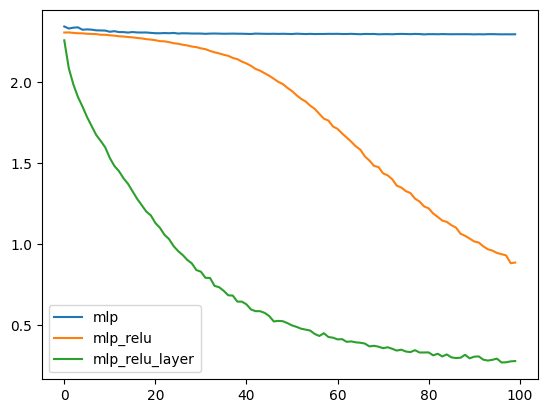

In [17]:
for i in ['mlp', 'mlp_relu', 'mlp_relu_layer']:
    plt.plot(torch.tensor(loss[i]).view(-1, 10).mean(dim=-1), label=i)
plt.legend()
plt.show()

In [18]:
# 模型过拟合
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(),
    nn.Linear( 20, 10)
)

loss['mlp_relu_layer_overfitting'] = train_model(model, optim.Adam(model.parameters(), lr=0.01), epochs=20)

epoch 0 train 0.200 val 0.222 test 0.224
epoch 1 train 0.125 val 0.158 test 0.158
epoch 2 train 0.101 val 0.139 test 0.133
epoch 3 train 0.108 val 0.140 test 0.139
epoch 4 train 0.069 val 0.130 test 0.112
epoch 5 train 0.072 val 0.127 test 0.126
epoch 6 train 0.059 val 0.127 test 0.123
epoch 7 train 0.066 val 0.118 test 0.118
epoch 8 train 0.058 val 0.119 test 0.120
epoch 9 train 0.056 val 0.129 test 0.116
epoch 10 train 0.036 val 0.122 test 0.115
epoch 11 train 0.064 val 0.150 test 0.130
epoch 12 train 0.043 val 0.127 test 0.131
epoch 13 train 0.034 val 0.146 test 0.116
epoch 14 train 0.031 val 0.123 test 0.115
epoch 15 train 0.037 val 0.158 test 0.125
epoch 16 train 0.029 val 0.155 test 0.114
epoch 17 train 0.039 val 0.156 test 0.145
epoch 18 train 0.028 val 0.154 test 0.128
epoch 19 train 0.022 val 0.151 test 0.127


In [19]:
m = nn.Dropout(0.5)
x = torch.randn(5, requires_grad=True)

In [20]:
x

tensor([-0.6472,  0.8302,  1.1706, -0.1630,  0.6412], requires_grad=True)

In [21]:
m.train()  # 最好指明
l = m(x)
l.sum().backward()
l, x.grad

(tensor([-1.2943,  0.0000,  0.0000, -0.3261,  1.2824], grad_fn=<MulBackward0>),
 tensor([2., 0., 0., 2., 2.]))

In [22]:
m.eval()  # 在评估模式下 dropout 不应该起作用，所以需要这个进行切换
m(x)

tensor([-0.6472,  0.8302,  1.1706, -0.1630,  0.6412], requires_grad=True)

In [24]:
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear( 20, 10)
)

loss['mlp_relu_layer_dropout'] = train_model(model, optim.Adam(model.parameters(), lr=0.01), epochs=20)

epoch 0 train 0.280 val 0.269 test 0.286
epoch 1 train 0.190 val 0.208 test 0.221
epoch 2 train 0.183 val 0.203 test 0.199
epoch 3 train 0.154 val 0.193 test 0.169
epoch 4 train 0.154 val 0.188 test 0.177
epoch 5 train 0.130 val 0.183 test 0.162
epoch 6 train 0.124 val 0.184 test 0.171
epoch 7 train 0.119 val 0.163 test 0.163
epoch 8 train 0.111 val 0.172 test 0.153
epoch 9 train 0.126 val 0.173 test 0.184
epoch 10 train 0.111 val 0.161 test 0.159
epoch 11 train 0.108 val 0.161 test 0.149
epoch 12 train 0.118 val 0.171 test 0.155
epoch 13 train 0.101 val 0.151 test 0.139
epoch 14 train 0.106 val 0.152 test 0.143
epoch 15 train 0.109 val 0.164 test 0.146
epoch 16 train 0.097 val 0.150 test 0.150
epoch 17 train 0.103 val 0.160 test 0.162
epoch 18 train 0.107 val 0.151 test 0.159
epoch 19 train 0.091 val 0.146 test 0.160


In [25]:
# 惩罚项
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(),
    nn.Linear( 20, 10)
)

_ = train_model(model, optim.Adam(model.parameters(), lr=0.01), epochs=20, penalty=True)

epoch 0 train 0.252 val 0.274 test 0.260
epoch 1 train 0.236 val 0.247 test 0.250
epoch 2 train 0.234 val 0.239 test 0.229
epoch 3 train 0.227 val 0.230 test 0.217
epoch 4 train 0.222 val 0.235 test 0.241
epoch 5 train 0.203 val 0.240 test 0.213
epoch 6 train 0.201 val 0.210 test 0.196
epoch 7 train 0.206 val 0.201 test 0.200
epoch 8 train 0.212 val 0.237 test 0.216
epoch 9 train 0.250 val 0.243 test 0.251
epoch 10 train 0.182 val 0.225 test 0.204
epoch 11 train 0.212 val 0.234 test 0.216
epoch 12 train 0.193 val 0.204 test 0.214
epoch 13 train 0.216 val 0.206 test 0.205
epoch 14 train 0.231 val 0.213 test 0.207
epoch 15 train 0.253 val 0.252 test 0.237
epoch 16 train 0.200 val 0.218 test 0.207
epoch 17 train 0.217 val 0.236 test 0.217
epoch 18 train 0.200 val 0.215 test 0.221
epoch 19 train 0.221 val 0.229 test 0.222


# 理解卷积

来自唐一旦老师的视频 [徒手实现卷积神经网络--结构详解与代码实现](https://www.bilibili.com/video/BV1yx4y1b7c9) 。

同时推荐观看飞天侠客的视频 [神经网络中永远也搞不明白的矩阵和CNN【白话DeepSeek04】](https://www.bilibili.com/video/BV1wXQhY8EJ6) 。

视频中给出的工具：

+ 卷积操作图示：https://setosa.io/ev/image-kernels/
+ GPU 对比页面用 AI 工具生成的代码：https://www.blackbox.ai/
+ 手写数字识别过程演示：https://felixzhang00.github.io/DL/mnist/
+ 3D CNN 网络可视化：https://adamharley.com/nn_vis/cnn/3d.html

In [31]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, (5, 5))
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 40, (5, 5))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(40 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        # x : (B, 1, 28, 28)
        B = x.shape[0]                       # (B,  1, 28, 28)
        x = F.relu(self.conv1(x))            # (B, 20, 24, 24)
        x = self.pool1(x)                    # (B, 20, 12, 12)
        x = F.relu(self.conv2(x))            # (B, 40,  8,  8)
        x = self.pool2(x)                    # (B, 40,  4,  4)
        x = F.relu(self.fc1(x.view(B, -1)))  # (B, 120)
        x = self.fc2(x)                      # (B, 10)
        return x

model = CNN()

In [35]:
eval_iters = 10


def estimate_loss(model):
    re = {}
    # 将模型切换为评估模式
    model.eval()
    re['train'] = _loss(model, train_loader)
    re['val'] = _loss(model, val_loader)
    re['test'] = _loss(model, test_loader)
    # 将模型切换为训练模式
    model.train()
    return re


@torch.no_grad()
def _loss(model, dataloader):
    # 估算模型效果
    loss = []
    acc = []
    data_iter = iter(dataloader)
    for t in range(eval_iters):
        inputs, labels = next(data_iter)
        # inputs: (500, 1, 28, 28)
        # labels: (500)
        B, C, H, W = inputs.shape
        #logits = model(inputs.view(B, -1))
        logits = model(inputs)
        loss.append(F.cross_entropy(logits, labels))
        # preds = torch.argmax(F.softmax(logits, dim=-1), dim=-1)
        preds = torch.argmax(logits, dim=-1)
        acc.append((preds == labels).sum() / B)
    re = {
        'loss': torch.tensor(loss).mean().item(),
        'acc': torch.tensor(acc).mean().item()
    }
    return re

In [36]:
def train_model(model, optimizer, epochs=10, penalty=False):
    lossi = []
    for e in range(epochs):
        for data in train_loader:
            inputs, labels = data
            #B, C, H, W = inputs.shape
            #logits = model(inputs.view(B, -1))
            logits = model(inputs)
            loss = F.cross_entropy(logits, labels)
            lossi.append(loss.item())
            if penalty:
                w = torch.cat([p.view(-1) for p in model.parameters()])
                loss += 0.001 * w.abs().sum() + 0.002 * w.square().sum()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        stats = estimate_loss(model)
        train_loss = f'{stats["train"]["loss"]:.3f}'
        val_loss = f'{stats["val"]["loss"]:.3f}'
        test_loss = f'{stats["test"]["loss"]:.3f}'
        print(f'epoch {e} train {train_loss} val {val_loss} test {test_loss}')
    return lossi

In [37]:
_ = train_model(model, optim.Adam(model.parameters(), lr=0.01))

epoch 0 train 0.040 val 0.062 test 0.042
epoch 1 train 0.026 val 0.047 test 0.038
epoch 2 train 0.028 val 0.048 test 0.035
epoch 3 train 0.015 val 0.041 test 0.037
epoch 4 train 0.016 val 0.047 test 0.039
epoch 5 train 0.013 val 0.049 test 0.034
epoch 6 train 0.037 val 0.075 test 0.050
epoch 7 train 0.015 val 0.051 test 0.046
epoch 8 train 0.013 val 0.068 test 0.055
epoch 9 train 0.012 val 0.050 test 0.039


In [38]:
estimate_loss(model)

{'train': {'loss': 0.010436898097395897, 'acc': 0.9973999857902527},
 'val': {'loss': 0.042675744742155075, 'acc': 0.9891999959945679},
 'test': {'loss': 0.04551061987876892, 'acc': 0.9873999357223511}}

In [40]:
class CNN2(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, (5, 5))
        self.ln1 = nn.LayerNorm([20, 24, 24])   # 层级归一化，与 AlexNet 中的做法类似
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 40, (5, 5))
        self.ln2 = nn.LayerNorm([40, 8, 8])
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(40 * 4 * 4, 120)
        self.dp = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        # x : (B, 1, 28, 28)
        B = x.shape[0]                       # (B,  1, 28, 28)
        x = F.relu(self.ln1(self.conv1(x)))  # (B, 20, 24, 24)
        x = self.pool1(x)                    # (B, 20, 12, 12)
        x = F.relu(self.ln2(self.conv2(x)))  # (B, 40,  8,  8)
        x = self.pool2(x)                    # (B, 40,  4,  4)
        x = F.relu(self.fc1(x.view(B, -1)))  # (B, 120)
        x = self.dp(x)
        x = self.fc2(x)                      # (B, 10)
        return x

model2 = CNN2()

In [41]:
_ = train_model(model2, optim.Adam(model2.parameters(), lr=0.01))

epoch 0 train 0.082 val 0.078 test 0.073
epoch 1 train 0.032 val 0.045 test 0.046
epoch 2 train 0.036 val 0.050 test 0.041
epoch 3 train 0.025 val 0.046 test 0.037
epoch 4 train 0.039 val 0.063 test 0.052
epoch 5 train 0.018 val 0.044 test 0.039
epoch 6 train 0.017 val 0.052 test 0.030
epoch 7 train 0.014 val 0.045 test 0.031
epoch 8 train 0.008 val 0.043 test 0.035
epoch 9 train 0.016 val 0.059 test 0.042


In [42]:
model2.eval()
estimate_loss(model2)

{'train': {'loss': 0.011416323482990265, 'acc': 0.9964000582695007},
 'val': {'loss': 0.04831470549106598, 'acc': 0.9893999099731445},
 'test': {'loss': 0.03911430388689041, 'acc': 0.9908000230789185}}

# 残差链接

来自唐一旦老师视频 [徒手实现卷积神经网络--残差网络（ResNet）](https://www.bilibili.com/video/BV1D1421r7sj)，同时你可以看笔记 7 ，这里代码的写法不一样。

In [67]:
# 卷积层的几个小技巧
channels = torch.randint(1, 10, (1, ))  # low, high, size
conv1 = nn.Conv2d(channels, channels, (3, 3), stride=1, padding=1)
x = torch.randn(1, channels, 28, 28)
print(x.shape, conv1(x).shape)

torch.Size([1, 2, 28, 28]) torch.Size([1, 2, 28, 28])


In [68]:
class ResidualBlockSimplified(nn.Module):

    def __init__(self, channels):
        super().__init__()
        self.covn1 = nn.Conv2d(channels, channels, (3, 3), stride=1, padding=1)
        self.covn2 = nn.Conv2d(channels, channels, (3, 3), stride=1, padding=1)

    def forward(self, x):
        inputs = x
        x = F.relu(self.covn1(x))
        x = self.covn2(x)
        # 残差连接
        out = x + inputs
        return F.relu(out)

In [69]:
model = ResidualBlockSimplified(3)
x = torch.randn(1, 3, 28, 28)
model(x).shape

torch.Size([1, 3, 28, 28])

In [70]:
# 这两个卷积操作的输出是一样形状的
stride = torch.randint(1, 10, (1,))
in_channels = torch.randint(1, 10, (1,))
out_channels = torch.randint(1, 10, (1,))
conv1 = nn.Conv2d(in_channels, out_channels, (3, 3), stride=stride, padding=1)
conv2 = nn.Conv2d(in_channels, out_channels, (1, 1), stride=stride, padding=0)
x = torch.randn(1, in_channels, 28, 28)
conv1(x).shape, conv2(x).shape

(torch.Size([1, 1, 4, 4]), torch.Size([1, 1, 4, 4]))

In [71]:
class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, (3, 3), stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, (3, 3), stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Conv2d(in_channels, out_channels, (1, 1), stride=stride, padding=0)
            self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        inputs = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        if self.downsample is not None:
            inputs = self.bn3(self.downsample(inputs))
        out = x + inputs
        out = F.relu(out)
        return out

In [72]:
class ResNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.block1 = ResidualBlock(1, 20)
        self.block2 = ResidualBlock(20, 40, stride=2)
        self.block3 = ResidualBlock(40, 60, stride=2)
        self.block4 = ResidualBlock(60, 80, stride=2)
        self.block5 = ResidualBlock(80, 100, stride=2)
        self.block6 = ResidualBlock(100, 120, stride=2)
        self.fc = nn.Linear(120, 10)

    def forward(self, x):
        # x : (B, 1, 28, 28)
        B = x.shape[0]
        x = self.block1(x)  # (B, 20, 28, 28)
        x = self.block2(x)  # (B, 40, 14, 14)
        x = self.block3(x)  # (B, 60,  7,  7)
        x = self.block4(x)  # (B, 80,  4,  4)
        x = self.block5(x)  # (B, 100, 2,  2)
        x = self.block6(x)  # (B, 120, 1,  1)
        x = self.fc(x.view(B, -1))
        return x